In [1]:
library(data.table)
library(ggplot2)

theme_update(plot.title = element_text(hjust = 0.5))

lung.cancer.data <- data.table(read.csv(file='MNlung.txt', sep='\t'))
radon.data <- data.table(read.csv(file='MNradon.txt', sep=' '))

setnames(lung.cancer.data, c('County', 'X'), c('county.name', 'county.id'))
setkey(lung.cancer.data, 'county.id')
setnames(radon.data, c('county'), c('county.id'))
setkey(radon.data, 'county.id')

In [2]:
lung.cancer.data[,expected:=exp.M + exp.F]
lung.cancer.data[,observed:=obs.M + obs.F]
lung.cancer.radon.data <- radon.data[,list(radon=mean(radon)),by=c('county.id')][
    lung.cancer.data[,c('county.name', 'county.id', 'expected', 'observed')], nomatch=FALSE]
lung.cancer.radon.data

county.id,radon,county.name,expected,observed
1,2.075000,Aitkin,76.9,92
2,3.212281,Anoka,600.5,677
3,3.175000,Becker,107.9,105
4,3.657143,Beltrami,105.7,101
5,3.775000,Benton,81.4,61
6,4.933333,Big Stone,27.4,32
7,7.014286,Blue Earth,144.2,112
8,5.825000,Brown,97.0,56
9,3.109091,Carlton,104.5,107
10,7.283333,Carver,135.4,104


# Default Priors

In [3]:
inla.model.default <- INLA::inla(
    observed ~ radon, family='poisson', E=expected,
    data=lung.cancer.radon.data,
    control.compute=list(config = TRUE),
    verbose=TRUE)
summary(inla.model.default)


Call:
c("INLA::inla(formula = observed ~ radon, family = \"poisson\", data = lung.cancer.radon.data, ",  "    E = expected, verbose = TRUE, control.compute = list(config = TRUE))" )

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.4052          0.0614          0.0241          0.4907 

Fixed effects:
               mean     sd 0.025quant 0.5quant 0.975quant    mode kld
(Intercept)  0.1702 0.0268     0.1176   0.1702     0.2229  0.1702   0
radon       -0.0361 0.0054    -0.0468  -0.0361    -0.0256 -0.0361   0

The model has no random effects

The model has no hyperparameters

Expected number of effective parameters(std dev): 2.076(0.00)
Number of equivalent replicates : 40.95 

Marginal log-Likelihood:  -397.17 

In [4]:
sample.inla <- function(inla.model, n, features) {
    samples <- INLA::inla.posterior.sample(n, inla.model, seed=0L, num.threads=4)
    samples <- data.frame(lapply(samples, function(sample) { sample$latent }))
    data.table(t(samples[features,]))
}

set.seed(2018)
inla.model.default.posterior.samples <- sample.inla(
    inla.model.default, 4096, c('(Intercept)', 'radon'))
setnames(inla.model.default.posterior.samples, c('intercept', 'radon'))
inla.model.default.posterior.samples

intercept,radon
0.1612277,-0.03579810
0.1741723,-0.03840495
0.2031893,-0.04368011
0.1376941,-0.03210575
0.1482165,-0.03086044
0.1536680,-0.03374224
0.1847827,-0.03932425
0.1582192,-0.03583910
0.1668990,-0.03140147
0.1672391,-0.03728720


In [5]:
plot.histogram <- function(feature, label) {
    p <- ggplot(mapping=aes_string(feature)) + 
      geom_histogram(bins=16) +
      xlab(label) +
      ggtitle(substitute('Sample Marginal Distribution for '*l, list(l=label)))
    p
}

png 
  2

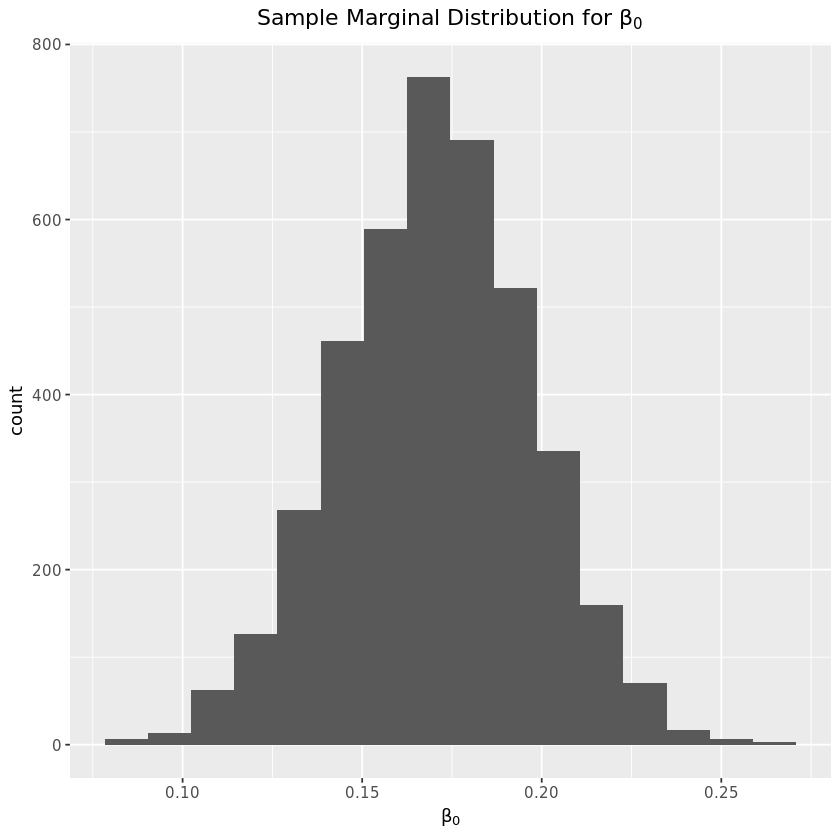

In [6]:
pdf('p3_beta_0.pdf', width=4, height=3)
p <- plot.histogram(inla.model.default.posterior.samples$intercept, quote(beta[0]))
p
dev.off()
p

png 
  2

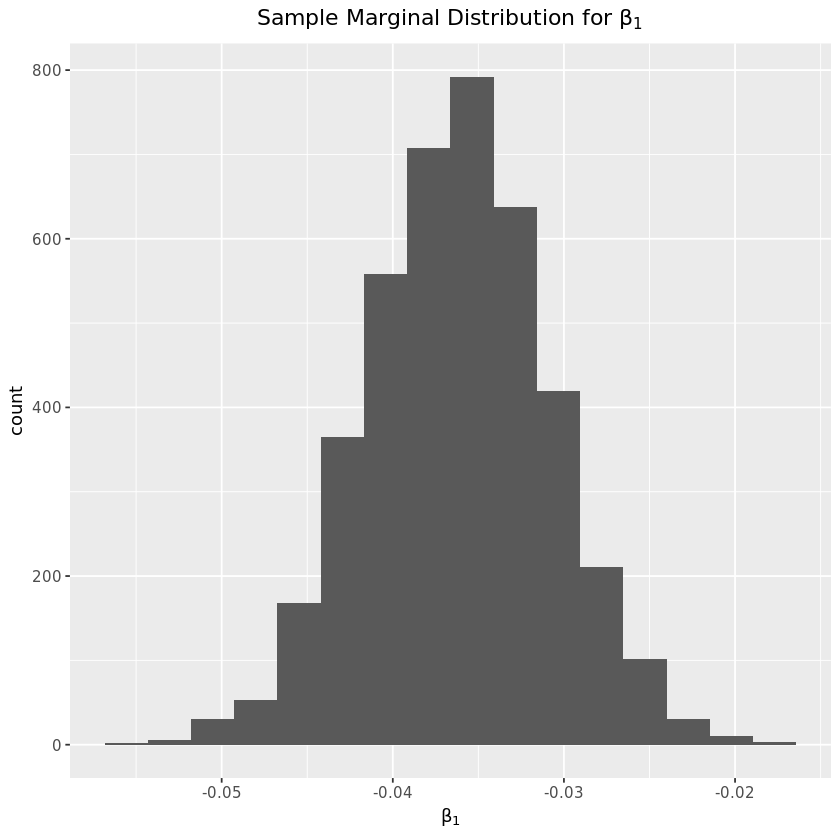

In [7]:
pdf('p3_beta_1.pdf', width=4, height=3)
p <- plot.histogram(inla.model.default.posterior.samples$radon, quote(beta[1]))
p
dev.off()
p

png 
  2

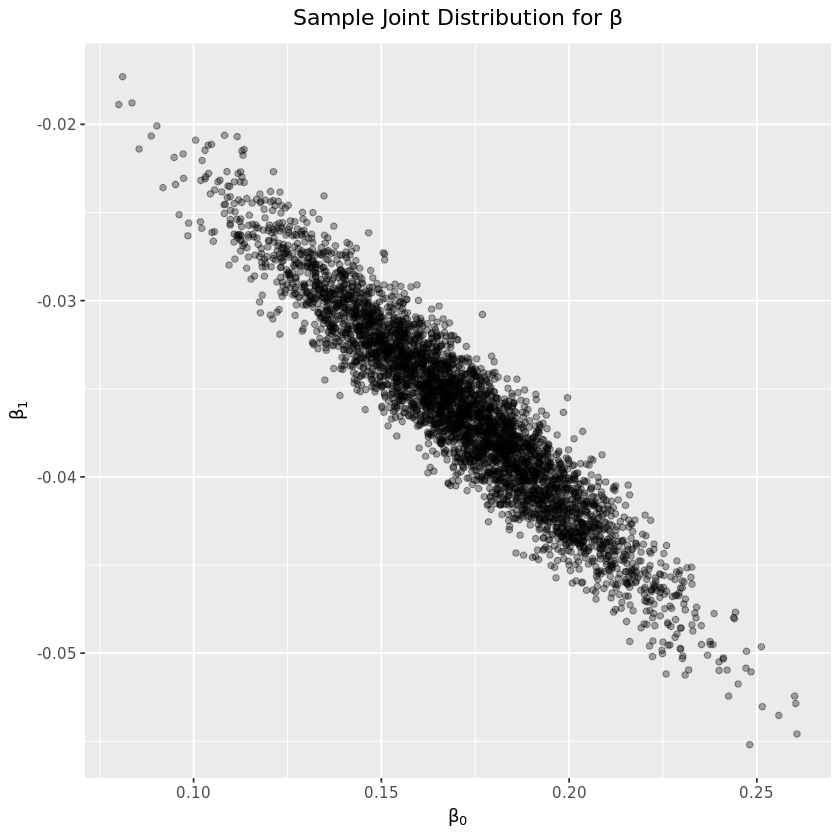

In [8]:
pdf('p3_beta_joint.pdf', width=4, height=3)
p <- ggplot(data=inla.model.default.posterior.samples, aes(intercept, radon)) +
  geom_point(alpha=1/3) +
  ggtitle(substitute('Sample Joint Distribution for '*beta)) +
  xlab(expression(beta[0])) +
  ylab(expression(beta[1]))
p
dev.off()
p

# Reparameterized Model

In [9]:
inla.model.reparameterized <- INLA::inla(
    observed ~ 1 + I(radon - mean(radon)), family='poisson', E=expected,
    data=lung.cancer.radon.data,
    control.fixed=list(
        mean.intercept=0,
        prec.intercept=1/0.21^2,
        mean=list(`I(radon - mean(radon))`=-0.02),
        prec=list(`I(radon - mean(radon))`=1/0.1^2)
    ),
    control.compute=list(config=TRUE),
    verbose=TRUE)
summary(inla.model.reparameterized)


Call:
c("INLA::inla(formula = observed ~ 1 + I(radon - mean(radon)), family = \"poisson\", ",  "    data = lung.cancer.radon.data, E = expected, verbose = TRUE, ",  "    control.compute = list(config = TRUE), control.fixed = list(mean.intercept = 0, ",  "        prec.intercept = 1/0.21^2, mean = list(`I(radon - mean(radon))` = -0.02), ",  "        prec = list(`I(radon - mean(radon))` = 1/0.1^2)))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.1276          0.0646          0.0130          0.2051 

Fixed effects:
                          mean     sd 0.025quant 0.5quant 0.975quant    mode
(Intercept)            -0.0208 0.0092    -0.0390  -0.0208    -0.0028 -0.0208
I(radon - mean(radon)) -0.0361 0.0054    -0.0467  -0.0361    -0.0255 -0.0360
                       kld
(Intercept)              0
I(radon - mean(radon))   0

The model has no random effects

The model has no hyperparameters

Expected number of effective parameters(std dev): 2.071(0.0

In [10]:
set.seed(2018)
inla.model.reparameterized.posterior.samples <- sample.inla(
    inla.model.reparameterized, 4096, c('(Intercept)', 'I(radon - mean(radon))'))
setnames(inla.model.reparameterized.posterior.samples, c('intercept', 'radon'))
inla.model.reparameterized.posterior.samples

intercept,radon
-0.031676746,-0.03480395
-0.014195993,-0.03535757
-0.019038489,-0.03562960
-0.042781992,-0.03782089
-0.008351120,-0.03801540
-0.030338528,-0.04200922
-0.027919810,-0.03996375
-0.021410045,-0.03017914
-0.052972762,-0.04308638
-0.004130190,-0.03384488


png 
  2

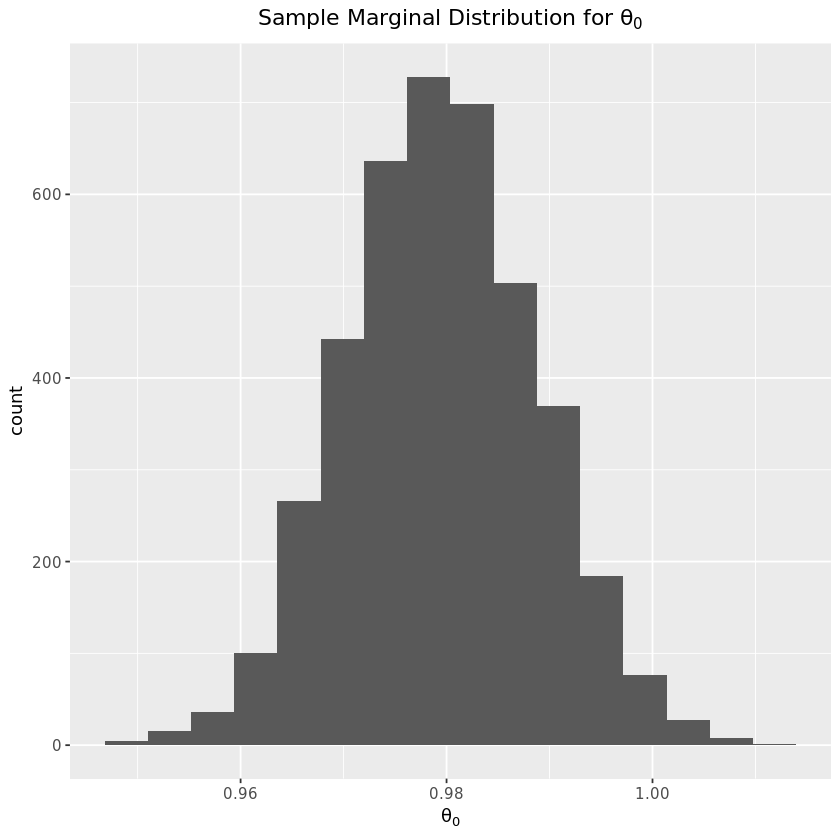

In [11]:
pdf('p3_theta_0.pdf', width=4, height=3)
p <- plot.histogram(exp(inla.model.reparameterized.posterior.samples$intercept), quote(theta[0]))
p
dev.off()
p

png 
  2

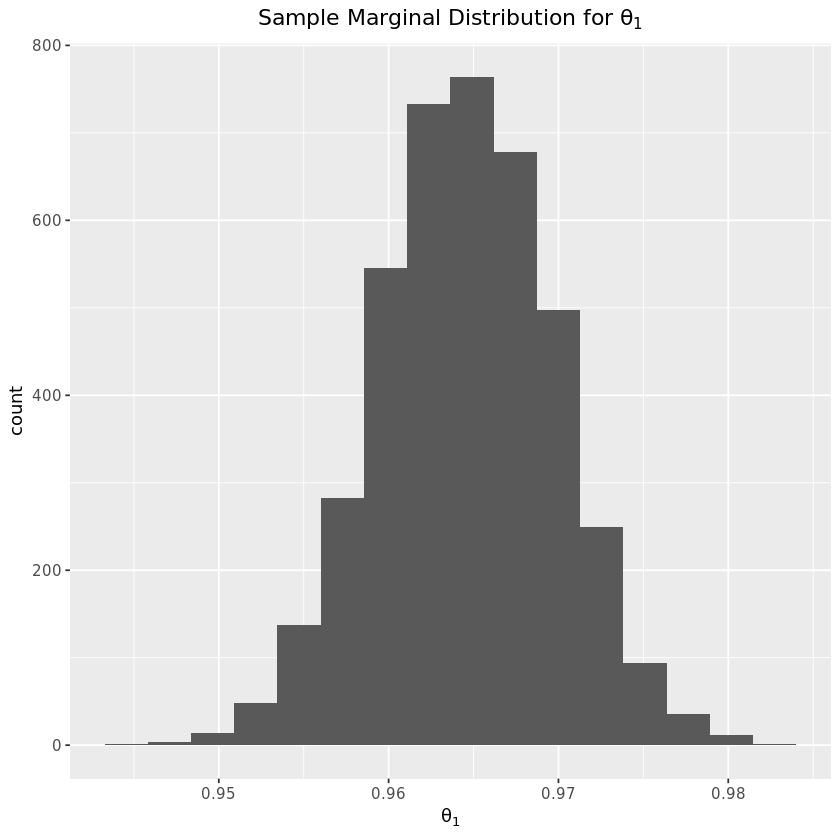

In [12]:
pdf('p3_theta_1.pdf', width=4, height=3)
p <- plot.histogram(exp(inla.model.reparameterized.posterior.samples$radon), quote(theta[1]))
p
dev.off()
p

png 
  2

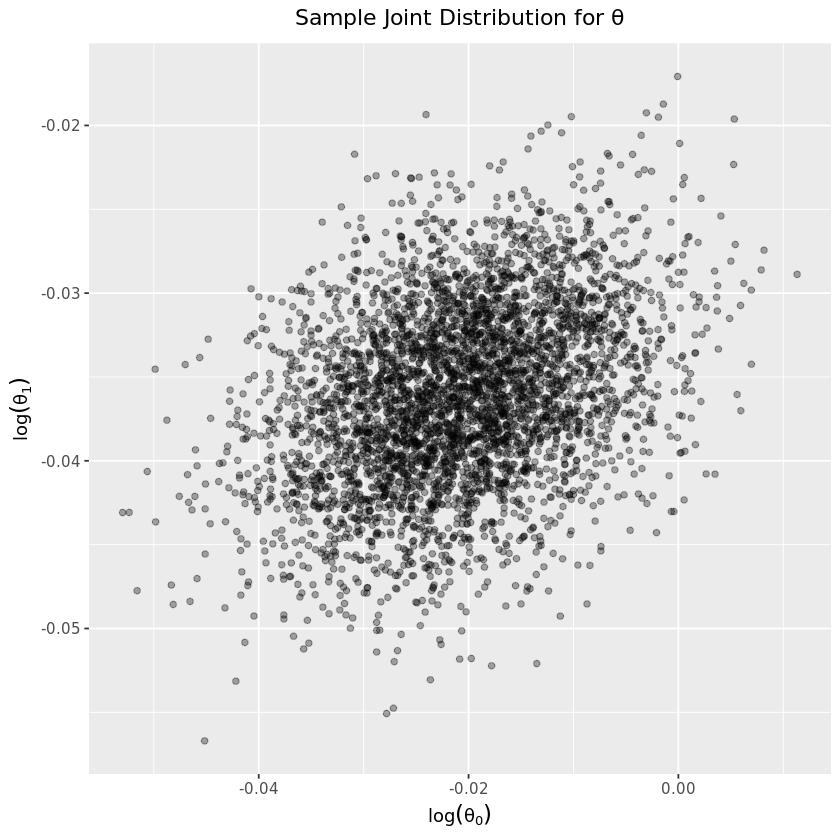

In [13]:
pdf('p3_theta_joint.pdf', width=4, height=3)
p <- ggplot(data=inla.model.reparameterized.posterior.samples, aes(intercept, radon)) +
  geom_point(alpha=1/3) +
  ggtitle(substitute('Sample Joint Distribution for '*theta)) +
  xlab(expression(log(theta[0]))) +
  ylab(expression(log(theta[1])))
p
dev.off()
p